In [1]:
import os
import numpy as np
import pandas as pd
from SimPEG import Mesh, Maps, DC, Utils
from pymatsolver import PardisoSolver
import matplotlib.pyplot as plt
from pylab import hist
from matplotlib import colors
%matplotlib inline

# Running 2D DC inversion using SimPEG

## Purpose

We demonstrate how 2D line of field DC data can be inverted in SimPEG. The field DC data is from Syscal Pro system and exported to csv format. Follwing eight steps will be illustrated to guide how 2D DC inversion can be run within `SimPEG`. 

- Step1: Read in DC data in csv format
- Step2: Generate `DC.IO` object
- Step3: Generate Mapping
- Step4: Form `Problem` object for physics
- Step5: Set uncertainty for the data
- Step6: Set initial model
- Step7: Run inversion
- Step8: Plot results

## Step1: Read in DC data in csv format

Example file used here is 'dc_data.csv'. We first load this csv file using `pandas` then input survey information to `DC.IO` object. 

### Read csv file using `pandas`

In [2]:
# Downlaod an example DC data

# from SimPEG.Utils.io_utils import download
# url = "https://storage.googleapis.com/simpeg/examples/dc_data.csv"
# fname = download(url, overwrite=True)

fname = os.path.sep.join(["..", "data", "dc_data.csv"])

In [3]:
# file name
# read csv using pandas
df = pd.read_csv(fname)
# header for ABMN locations
header_loc = ['Spa.'+str(i+1) for i in range(4)]
# Apparent resistivity
header_apprho = df.keys()[6]

In [4]:
df.describe()

,Unnamed: 0,Spa.1,Spa.2,Spa.3,Spa.4,Rho,Dev.,M,Sp,Vp,...,Channel,Overload,Tx-Bat,Rx-Bat,Temp.,Gapfiller,Synch,Cole Tau,Cole M,Cole rms
count,0.0,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,...,1211.000000,1211.0,1211.000000,1211.000000,1211.000000,1211.0,1211.000000,1211.0,1211.0,1211.0
mean,NaN,214.219653,219.219653,255.780347,260.780347,181.833691,42.542543,34.878596,0.084979,-108.493249,...,4.620149,0.0,11.688489,11.828159,46.093064,0.0,0.145334,0.0,0.0,0.0
std,NaN,125.705571,125.705571,125.705571,125.705571,157.068458,104.394421,146.461954,142.643142,242.930941,...,2.836490,0.0,0.109590,0.051543,0.667536,0.0,0.352583,0.0,0.0,0.0
min,NaN,0.000000,5.000000,10.000000,15.000000,-12.080000,0.000000,-163.520000,-549.960000,-2397.696000,...,1.000000,0.0,11.470000,11.620000,44.600000,0.0,0.000000,0.0,0.0,0.0
25%,NaN,105.000000,110.000000,150.000000,155.000000,71.250000,0.520000,0.175000,-39.945000,-75.698000,...,2.000000,0.0,11.590000,11.800000,45.600000,0.0,0.000000,0.0,0.0,0.0
50%,NaN,215.000000,220.000000,255.000000,260.000000,139.170000,4.820000,2.030000,-0.910000,-11.334000,...,4.000000,0.0,11.710000,11.850000,46.100000,0.0,0.000000,0.0,0.0,0.0
75%,NaN,320.000000,325.000000,365.000000,370.000000,254.965000,25.470000,7.965000,38.005000,-2.512500,...,7.000000,0.0,11.800000,11.870000,46.500000,0.0,0.000000,0.0,0.0,0.0
max,NaN,460.000000,465.000000,470.000000,475.000000,1107.340000,816.490000,999.990000,528.160000,0.143000,...,10.000000,0.0,11.850000,11.920000,48.000000,0.0,1.000000,0.0,0.0,0.0


There are a number of columns in the pandas' data frame, `df`. Here we only select ABMN locations and the apparent resistivity, which will be input variabls of `DC.IO` object. 

In [5]:
# Number of the data
ndata = df[header_loc[0]].values.size
# ABMN locations
a = np.c_[df[header_loc[0]].values, np.zeros(ndata)]
b = np.c_[df[header_loc[1]].values, np.zeros(ndata)]
m = np.c_[df[header_loc[2]].values, np.zeros(ndata)]
n = np.c_[df[header_loc[3]].values, np.zeros(ndata)]
# Apparent resistivity
apprho = df[header_apprho].values

## Step2: Generate `DC.IO` object

`DC.IO` will enable us to form `DC survey` and `Mesh` which are required information to run DC simulation. Survey information that we have selected are required to be input to `DC.IO`. Based upon the survey information, 2D mesh will be generated. 

In [6]:
# DC.IO object
IO = DC.IO()
# Generate DC survey using IO object
dc_survey = IO.from_ambn_locations_to_survey(
    a, b, m, n,
    survey_type='dipole-dipole', 
    data_dc=apprho,
    data_dc_type='apparent_resistivity'
)

/Users/lindseyjh/git/python_symlinks/SimPEG/EM/Static/DC/IODC.py:228: UserWarning: code under construction - API might change in the future
  "code under construction - API might change in the future"


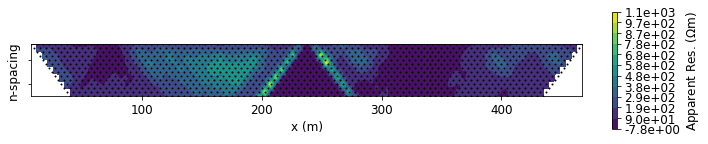

In [7]:
IO.plotPseudoSection(data_type='apparent_resistivity', scale='linear')

In [8]:
# Generate 2D tensor mesh 
mesh, actind = IO.set_mesh(dx=2.5)

/Users/lindseyjh/git/python_symlinks/SimPEG/EM/Static/DC/IODC.py:505: UserWarning: dz (1.25 m) is set to dx (2.5 m) / 2
  "dz ({} m) is set to dx ({} m) / {}".format(dz, dx, 2)


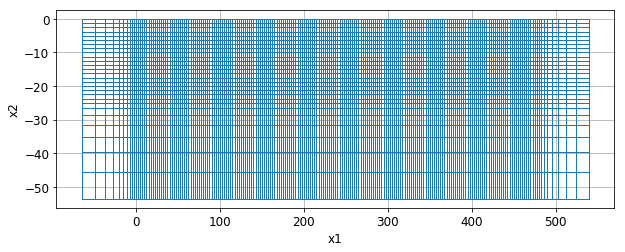

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
mesh.plotGrid(ax=ax)
plt.gca().set_aspect(4)

## Step3: Generate Mapping

When inverting DC data often inversion model, $m$, differ from the conductivity, $\sigma$. For instance, often logarithmic conductivity is used as an inversion model:

$$ m = log (\sigma) $$

Mapping is an opposite way to think about this, which can be written as 

$$ \sigma = \mathcal{M} (m) $$

Thus, the mapping, $\mathcal{M} (m)$ transform from a model space to a physical property space. Here we use exponential map:

$$ \sigma = exp(m) $$

which is equivalent to logarithmic conductivity. 

In [10]:
# Exponential map
sigmaMap = Maps.ExpMap(mesh)

In [11]:
print (sigmaMap * np.ones(mesh.nC) * np.log(1./100.))

[-12.51815043 -12.51815043 -12.51815043 ... -12.51815043 -12.51815043
 -12.51815043]


## Step4: Form `Problem` object for physics

`Problem` object has a capability to evaluate predicted data, $d^{pred}=F[m]$, for a given model, $m$. 
Survey information and Mapping are required to evaluate the predicted data. Here we use `DC.Problem2D_N`. Potentials are defined on the nodes and 2.5D formulation is used. 

In [12]:
# Problem ojbect
prob = DC.Problem2D_N(
    mesh, sigmaMap=sigmaMap, storeJ=True,
    Solver=PardisoSolver
)
if prob.pair:
    prob.unpair()
if dc_survey.pair:
    dc_survey.unpair()
# Paring survey and problem
prob.pair(dc_survey)

## Step5: Set uncertainty for the data

A minimal condition for the DC inversion is making sure finding a model that fits 
the observed data. Data misfit is often defined as 

$$ \phi_d = \Sigma_{i}^{N}\Big(\frac{d^{pred}_i-d^{obs}_i}{\varepsilon_i}\Big)^2 $$, 

where $\varepsilon_i$ is the uncertainty at $i$-th dataum. We often assign percentage ($\%$) and floor as uncertainty, which can be written as:

$$ \varepsilon_i = \% \ |d^{obs}_i| + floor $$

Note that the unit of the data is volatage (V) and hence apparent resistivity need to be converted to voltage. 

Text(0.5, 0, 'Log 10 voltage (V)')

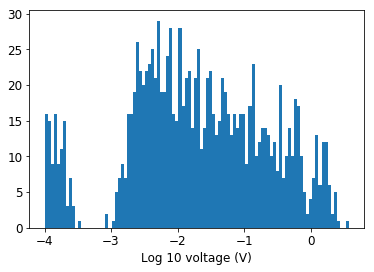

In [13]:
out = hist(np.log10(abs(IO.voltages)+1e-4), bins=100)
plt.xlabel("Log 10 voltage (V)")

In [14]:
# Set the observed data as the measured voltage
dc_survey.dobs = IO.voltages.copy()
# Set percentage as 5%
std = 0.05
# Set floor as 1e-3 V
eps = 1e-3

## Step6: Set initial model

For any gradient-based inversion setting a reasonable initial model is very important. 
Here we set an initial model based upon the observed apparent resistivity values. 

Text(0.5, 0, 'Log 10 apparent resistivity')

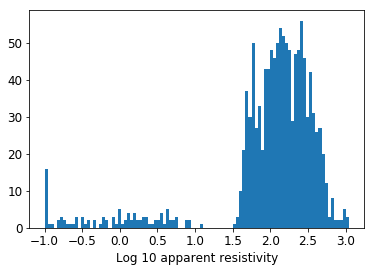

In [15]:
out = hist(np.log10(abs(IO.apparent_resistivity)+1e-1), bins=100)
plt.xlabel("Log 10 apparent resistivity")

In [16]:
m0 = np.ones(mesh.nC) * np.log(1./100.)

## Step7: Run inversion

In order to run DC inversion, multiple ojbects are required:

- `DataMifit`: Data misfit L2
- `Regularization`: Tikhonov Style regularization
- `Optimization`: Projected Gauss Newtown 
- `InvProblem`: Statement of the inversion
- `Directives`: Conductor of the inversion
- `Inversion`: Running inversion


In [17]:
from SimPEG import (DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)

## DataMisfit (L2)
dmisfit = DataMisfit.l2_DataMisfit(dc_survey)
uncert = abs(dc_survey.dobs.copy()) * std + eps
dmisfit.W = 1./uncert

## Regularization
# Map for a regularization
regmap = Maps.IdentityMap(nP=int(actind.sum()))
reg = Regularization.Simple(mesh, indActive=actind, mapping=regmap)
reg.alpha_s = 1.     
reg.alpha_x = 1.
reg.alpha_y = 1.
# This is for sparse inversion
# reg = Regularization.Sparse(mesh, mapping=regmap)        
# reg.norms = np.c_[0., 2., 1., 1.]        
# reg.gradientType = 'components'
# IRLS = Directives.Update_IRLS(maxIRLSiter=15, minGNiter=1)        

## Optimization
maxIter = 10
upper = np.log(1e1)
lower = np.log(1e-4)
opt = Optimization.ProjectedGNCG(maxIter=maxIter, upper=upper, lower=lower)

## InvProblem
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)

## Directives
# 1: Initial beta estimation
beta0_ratio = 1.
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
# 2: Beta cooling schedule
coolingFactor = 2.
coolingRate = 1
beta = Directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=coolingRate
)
# 2: Target misfit
target = Directives.TargetMisfit()
# 4: Save outputs
save = Directives.SaveOutputEveryIteration()
directiveList = [
    beta, betaest, save, target
]        
# This is for Sparse inversion
#         directiveList = [
#             beta, betaest, IRLS, save
#         ]

## Inversion
inv = Inversion.BaseInversion(
    invProb, directiveList=directiveList, 
)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [18]:
# Run inversion
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Compute fields
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2019-01-26-16-17.txt'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
Compute fields
   0  9.18e+01  9.01e+05  0.00e+00  9.01e+05    3.02e+02      0              
Compute fields
   1  4.59e+01  8.59e+04  5.55e+01  8.85e+04    2.55e+02      0              
Compute fields
   2  2.30e+01  2.36e+04  1.75e+02  2.76e+04    2.18e+02      0   Skip BFGS  
Compute fields
   3  1.15e+01  1.31e+04  3.47e+02  1.71e+04    1.88e+02      0   Skip BFGS  
Compute fields
   4  5.74e+00  6.55

## Step 8: Plot results

Here we plot results of the DC inversion. 

- Recovered 2D conductivity model
- Observed and Predicted data
- Tikhnov curves

### Recovered conductivity model

In [19]:
# Transform log conductivity model to conductivity 
sigma_est = sigmaMap * mopt

In [20]:
# Extract Core Mesh and corresponding indices
actind_core, mesh_core = Utils.ExtractCoreMesh(IO.xyzlim, mesh)

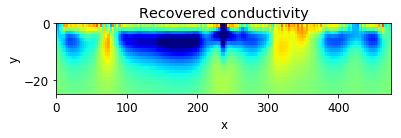

In [21]:
mesh_core.plotImage(sigma_est[actind_core], pcolorOpts={'norm':colors.LogNorm(), 'cmap':'jet'}, clim=(1e-3, 1e-1))
plt.title("Recovered conductivity")
plt.gca().set_aspect(4)

### Observed and Predicted data

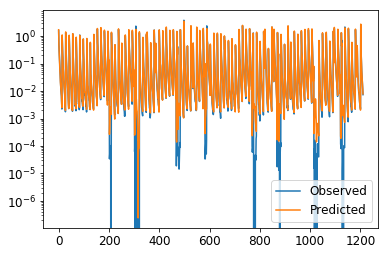

In [22]:
plt.semilogy(abs(dc_survey.dobs))
plt.semilogy(abs(invProb.dpred))
plt.legend(("Observed", "Predicted"))

### Tikhnov curves

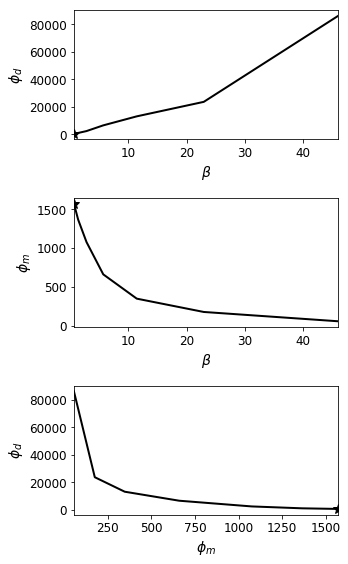

In [23]:
save.plot_tikhonov_curves()